In [1]:
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import xgboost as xgb


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('netflix_reviews.csv')

In [3]:
# Data processing
df = df.dropna(subset=['userName', 'content'])
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()
    return text

def is_english(text):
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

df['cleaned_content'] = df['content'].apply(clean_text)
df = df[df['cleaned_content'].apply(is_english)]
df = df[df['cleaned_content'].str.strip() != '']

# Create a sentiment label column based on the score column 创建情感标签列，基于score列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)
df['at'] = pd.to_datetime(df['at'])
df = df[['cleaned_content', 'sentiment','at']]

# Convert sentiment labels to numerical values
label_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['sentiment'] = df['sentiment'].map(label_map)


In [4]:
# BERT Processing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(texts, tokenizer, model, max_length=256):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    return cls_embeddings

def batch_embed_texts(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = embed_text(batch_texts, tokenizer, model)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Get BERT embedding vector
texts = df['cleaned_content'].tolist()
batch_size = 32

# Use multithreaded parallel processing    使用多线程并行处理
with ThreadPoolExecutor() as executor:
    bert_embeddings = np.vstack(list(executor.map(lambda x: embed_text([x], tokenizer, model), texts)))

# Add BERT embedding vectors to the dataframe  将BERT嵌入向量添加到数据框
df['bert_embeddings'] = list(bert_embeddings)

# Partition the dataset by date
split_date = '2024-01-01'
train_df = df[df['at'] < split_date]
test_df = df[df['at'] >= split_date]

# Extract BERT embedding vectors and sentiment labels 提取BERT嵌入向量和情感标签
X_train = np.vstack(train_df['bert_embeddings'].values)
y_train = train_df['sentiment'].values
X_test = np.vstack(test_df['bert_embeddings'].values)
y_test = test_df['sentiment'].values

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Overall Accuracy: 75.09%

Logistic Regression Model Report:
              precision    recall  f1-score   support

    Negative       0.90      0.76      0.83      9962
     Neutral       0.18      0.42      0.25      1126
    Positive       0.79      0.81      0.80      4940

    accuracy                           0.75     16028
   macro avg       0.62      0.66      0.63     16028
weighted avg       0.82      0.75      0.78     16028



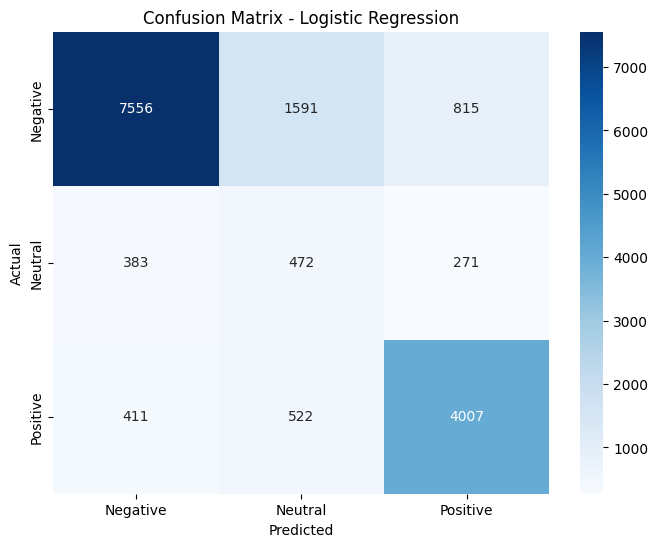

In [9]:
# Logistc Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 75.09%

Random Forest Model + Class Weight Report:
              precision    recall  f1-score   support

    Negative       0.90      0.76      0.83      9962
     Neutral       0.18      0.42      0.25      1126
    Positive       0.79      0.81      0.80      4940

    accuracy                           0.75     16028
   macro avg       0.62      0.66      0.63     16028
weighted avg       0.82      0.75      0.78     16028



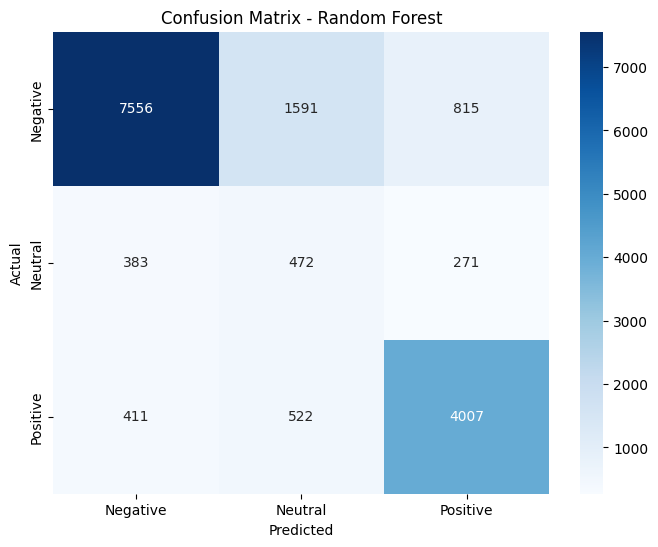

In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nRandom Forest Model + Class Weight Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Overall Accuracy: 80.87%

XGBoost Model Report:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      9962
     Neutral       0.16      0.02      0.03      1126
    Positive       0.73      0.85      0.78      4940

    accuracy                           0.81     16028
   macro avg       0.58      0.58      0.56     16028
weighted avg       0.77      0.81      0.78     16028



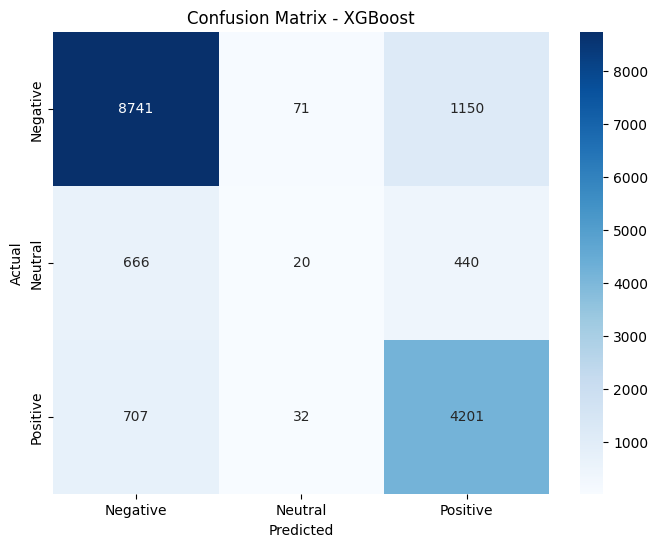

In [5]:
# xgboost

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_xgb) * 100))

print("\nXGBoost Model Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Negative', 'Neutral', 'Positive']))


conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7019 - loss: 0.7809 - val_accuracy: 0.8219 - val_loss: 0.4926
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7513 - loss: 0.6629 - val_accuracy: 0.8219 - val_loss: 0.4878
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7544 - loss: 0.6535 - val_accuracy: 0.8204 - val_loss: 0.4922
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7546 - loss: 0.6526 - val_accuracy: 0.8257 - val_loss: 0.4879
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7589 - loss: 0.6440 - val_accuracy: 0.8247 - val_loss: 0.4861
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Overall Accuracy: 82.63%

LSTM Model + Dropout and BatchNormalization Report:
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88      9962
     Neutral       0.00      0.00      0.00      1126
    Positive       0.77      0.84      0.80      4940

    accuracy 

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

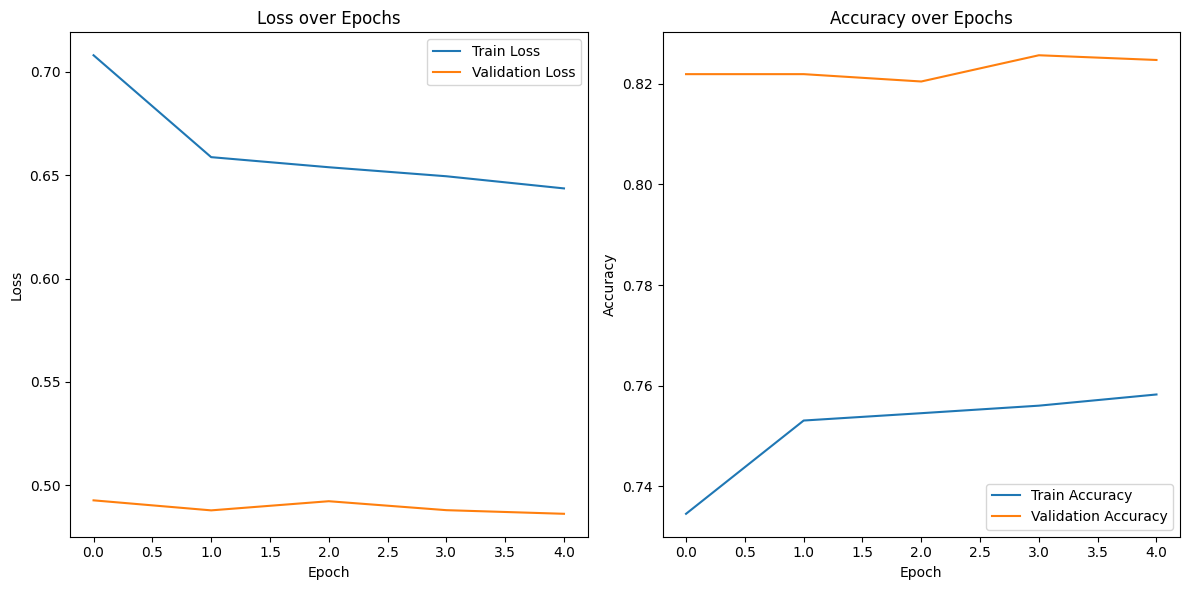

In [6]:
# LSTM
# Reshape the data to add a time step dimension
X_train = np.expand_dims(X_train, axis=1)  # Reshape to (samples, timesteps=1, features)
X_test = np.expand_dims(X_test, axis=1)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred_classes = y_pred_prob.argmax(axis=-1)

print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("\nLSTM Model + Dropout and BatchNormalization Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
